In [1]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

from create_etf_regimes import create_regimes

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.random.seed(0)

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 1.0,
})

## Create regime files

In [3]:
etf_file = "./SPY_2018.csv"
vix_file = "./vixcurrent.csv"
regime_thresh = [(0, 20), (20, 100)]
create_regimes(etf_file, vix_file, regime_thresh, half_life=10)

## Reading the data from CSV file

In [4]:
# regime = 0.0 # for high vol
# regime = -1.0 # for low vol
regime = None # for generating plain synthetic prices

In [5]:
if regime is None:
    filepath = f"./SPY_2018.csv"
else:
    filepath = f"./SPY_regime_{regime}_ewm.csv"
spy_df = pd.read_csv(filepath)
spy_df["date"] = pd.to_datetime(spy_df["date"]).dt.date
spy_df = spy_df.set_index("date")
spy_df['log_ret'] = (np.log(spy_df.Adj_Close) - np.log(spy_df.Adj_Close.shift(1))).dropna()
spy_df = spy_df.fillna(0)
spy_df.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,log_ret
date,,,,,,,,,,,,,
2013-01-02,145.110001,146.149994,144.729996,146.059998,192059000,0.0,1,125.066933,125.963279,124.739416,125.885713,192059000,0.000000
2013-01-03,145.990005,146.369995,145.339996,145.729996,144761800,0.0,1,125.825388,126.152893,125.265160,125.601292,144761800,-0.002262
2013-01-04,145.970001,146.610001,145.669998,146.369995,116817700,0.0,1,125.808147,126.359748,125.549581,126.152893,116817700,0.004382
2013-01-07,145.850006,146.110001,145.429993,145.970001,110002500,0.0,1,125.704726,125.928810,125.342727,125.808147,110002500,-0.002737
2013-01-08,145.710007,145.910004,144.979996,145.550003,121265100,0.0,1,125.584064,125.756437,124.954885,125.446161,121265100,-0.002881


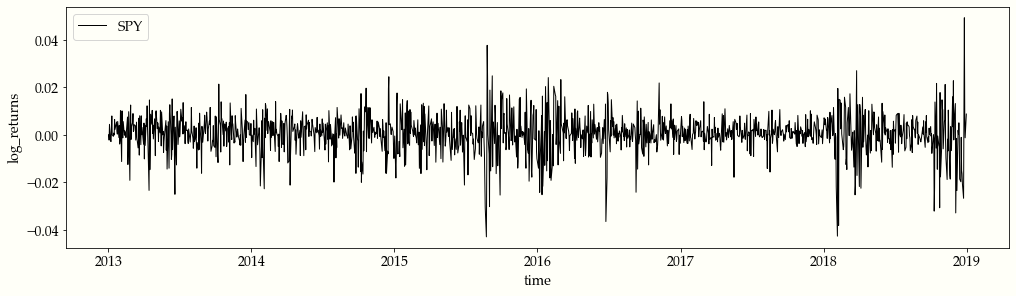

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))
spy_df.plot(y="log_ret", label='SPY', ax=ax)
ax.set(xlabel='time', ylabel='log_returns')
ax.legend();

## Defining the Stochastic Volatility Model

In [7]:
def make_stochastic_volatility_model(data):
    with pm.Model() as model:
        step_size = pm.Exponential('step_size', 10)
        volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, shape=len(data))
        
        nu = pm.Exponential('nu', 0.001)
        returns = pm.StudentT('returns',
                        nu=nu,
                        lam=np.exp(-2*volatility),
                        observed=data["log_ret"])
    return model

stochastic_vol_model = make_stochastic_volatility_model(spy_df)

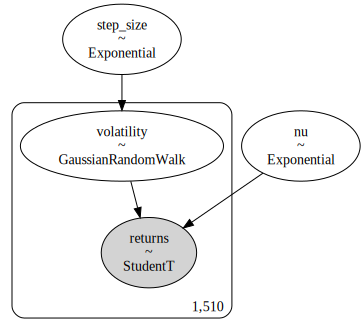

In [8]:
pm.model_to_graphviz(stochastic_vol_model)

In [9]:
with stochastic_vol_model:
    prior = pm.sample_prior_predictive(500)

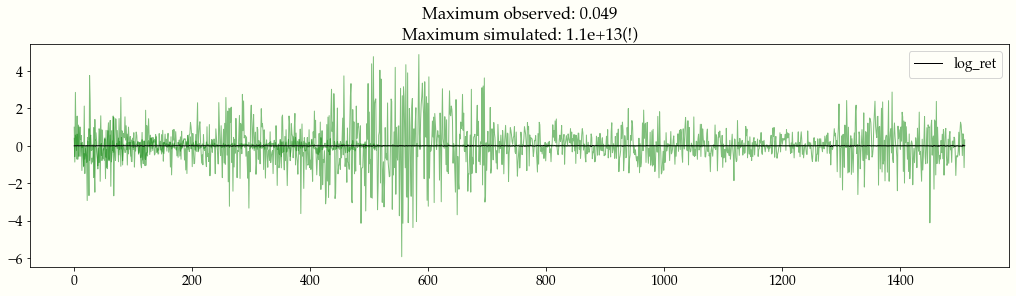

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
spy_df['log_ret'].reset_index().plot(ax=ax, lw=1, color='black')
ax.plot(prior['returns'][4:6].T, 'g', alpha=0.5, lw=1, zorder=-10)

max_observed, max_simulated = np.max(np.abs(spy_df['log_ret'])), np.max(np.abs(prior['returns']))
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

## Fitting the Model on Observed Returns

In [11]:
with stochastic_vol_model:
    # trace = pm.sample(2000, tune=2000, target_accept=0.9)
    trace = pm.sample(2000, tune=8000, target_accept=0.9)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 8_000 tune and 2_000 draw iterations (32_000 + 8_000 draws total) took 563 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
with stochastic_vol_model:
    posterior_predictive = pm.sample_posterior_predictive(burned_trace)

## Plotting the Model Trace

/Users/sujitkhanna/Desktop/Talos_Research/Synthetic_Prices_MCMC/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


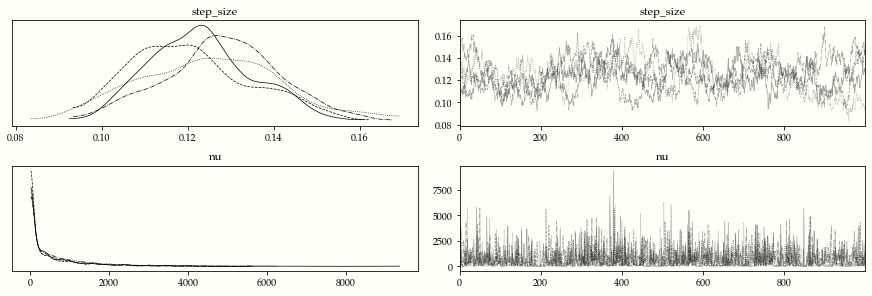

In [13]:
pm.traceplot(burned_trace, var_names=['step_size', 'nu']);

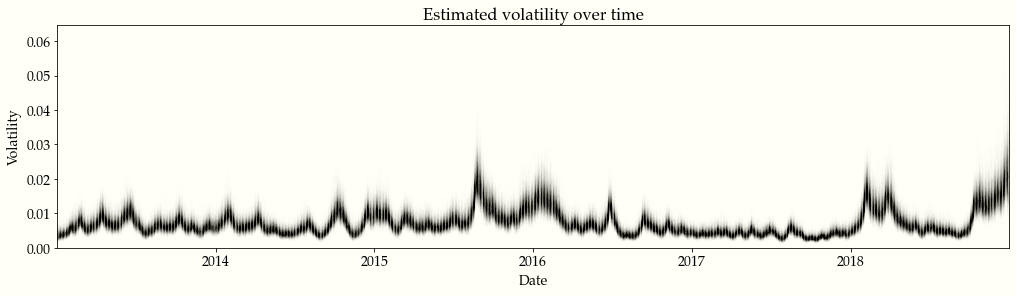

In [14]:



fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(burned_trace['volatility'])[::5].T
x_vals = np.vstack([spy_df.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');

Text(0.5, 1.0, 'Posterior volatility')

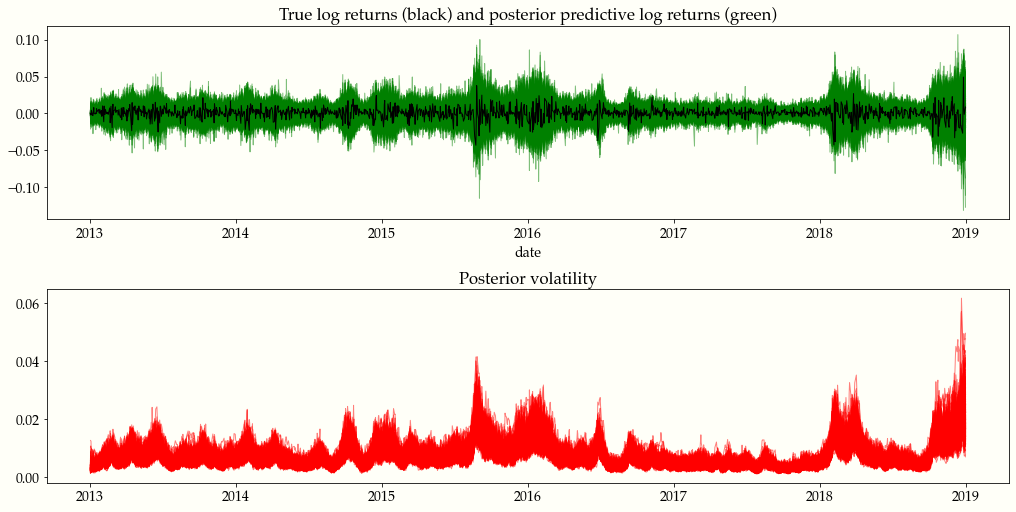

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7))
spy_df['log_ret'].plot(ax=axes[0], color='black')

axes[1].plot(x_vals, np.exp(burned_trace['volatility'][::5].T), 'r', alpha=0.5, )
axes[0].plot(x_vals, posterior_predictive['returns'][::5].T, 'g', alpha=0.5, zorder=-10)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility")


## Performing Posterior Predictive Checks

/Users/sujitkhanna/Desktop/Talos_Research/Synthetic_Prices_MCMC/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/sujitkhanna/Desktop/Talos_Research/Synthetic_Prices_MCMC/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


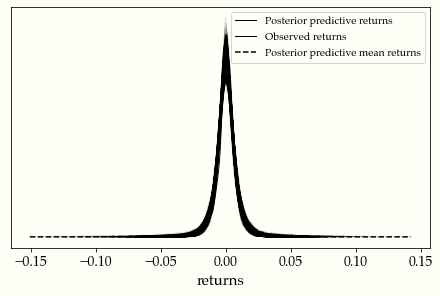

In [16]:
gen_data = az.from_pymc3(burned_trace, posterior_predictive=posterior_predictive)
az.plot_ppc(gen_data);

## Reconstructing SPY Prices from observed returns

<AxesSubplot:title={'center':'True SPY Price'}, xlabel='date'>

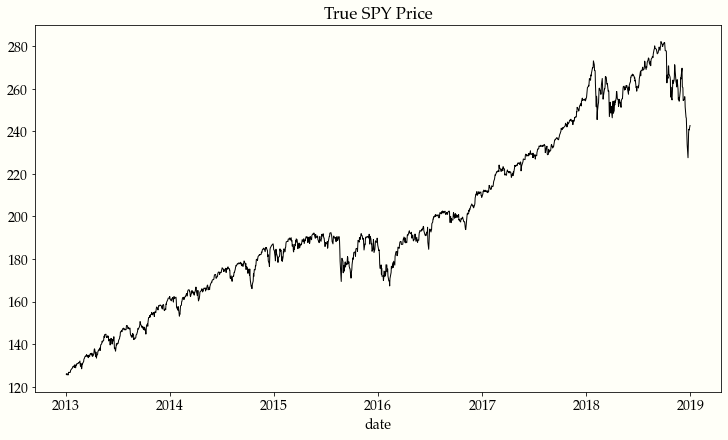

In [17]:
# Plot original returns 
act_idx = spy_df["Adj_Close"].iloc[0]*(np.exp(spy_df['log_ret'])).cumprod()
act_idx.plot(figsize=(10, 6), title= "True SPY Price")

Text(0.5, 0.98, 'Synthetic SPY Prices')

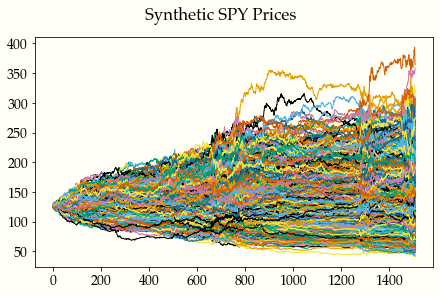

In [18]:
from pylab import rcParams
fig = plt.figure()
rcParams['figure.figsize'] = 10, 6
for i in range(len(posterior_predictive['returns'])):
    plt.plot(spy_df["Adj_Close"].iloc[0]*(np.exp(posterior_predictive['returns'][i])).cumprod())
fig.suptitle('Synthetic SPY Prices')

In [19]:
synthetic_df = pd.DataFrame(posterior_predictive['returns']).T
synthetic_df.columns = [f"price {str(x)}" for x in range(posterior_predictive['returns'].shape[0])]
actual_df = spy_df['log_ret'].to_frame()
actual_df.head()

,log_ret
date,
2013-01-02,0.000000
2013-01-03,-0.002262
2013-01-04,0.004382
2013-01-07,-0.002737
2013-01-08,-0.002881


## Selecting the Best Synthetic Prices using a Wasserstein-1 distance

In [20]:
from scipy.stats import wasserstein_distance
min_threshold=50
price_list = []
for name, cols in synthetic_df.items():
    cols = pd.to_numeric(cols, errors='coerce').ffill()
    kl_d = wasserstein_distance(actual_df.values.flatten(), cols.values)
    df = pd.DataFrame({"series_name": name, "kl_d": kl_d}, index=[1])
    price_list.append(df)
full_df = pd.concat(price_list)
full_df = full_df.sort_values(["kl_d"], ascending=True)
best_prices = full_df["series_name"].iloc[:min_threshold].values.tolist()
selected_df = synthetic_df[best_prices]
selected_df.to_csv(f'./SYN_{regime}_SPY_2018_top{min_threshold}_file.csv')

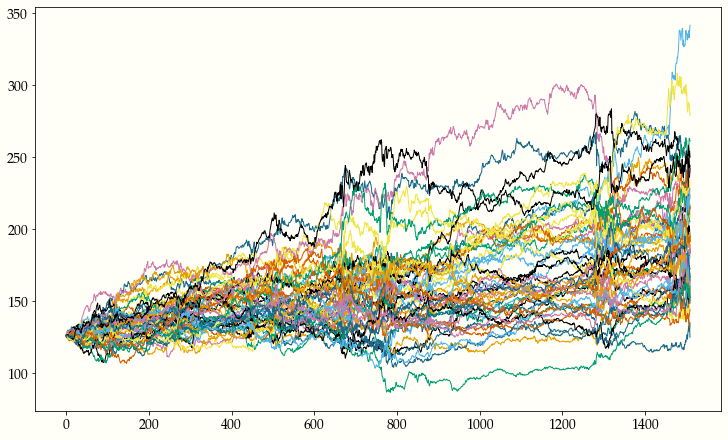

In [21]:
syn_prices_df = spy_df["Adj_Close"].iloc[0]*(1 + selected_df).cumprod()
plt.plot(syn_prices_df);